In [90]:
from pathlib import Path 
import torch 
import numpy as np
from datasets import load_dataset, Dataset
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
import deepchopper
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

In [91]:
from rich.console import Console
from rich.text import Text

def highlight_target(seq: str, start: int, end: int, style="bold magenta"):
    text = Text(seq)
    console = Console()
    text.stylize(style, start, end)
    console.print(text)

def hightlight_predict(seq: str, target_start: int, target_end:int, predict_start: int, predict_end: int):
    text = Text(seq)
    console = Console()
    
    text.stylize("#adb0b1", target_start, target_end)
    text.stylize("bold magenta", predict_start, predict_end)
    
    console.print(text)

In [92]:
root_dir = Path("/projects/b1171/ylk4626/project/DeepChopper")

In [111]:
train_file = root_dir / "tests/data/test_input.parquet"
dataset = load_dataset("parquet", data_files={'train': train_file.as_posix()})

In [113]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'seq', 'qual', 'target'],
        num_rows: 5000
    })
})

In [153]:
seq1 = dataset['train']['seq'][0]

In [155]:
seq1

'GCAGCTATGAATGCAAGGCCACAAGGTGGATGGAAGAGTTGTGGAACCAAAGAGCTGTCTTCCAGAGAAGATTTCGAGATAAGTCGCCCATCAGTGAACAAGATATTGTTGGTGGCATTTGATGAGAACGTTCCAAGATTATTGACAGATTAGTGAAAAGTAAGATTGAAATCATGACTGACCGTAAGTGGCAAGAAAGGGCTTTTGCCTTTGTAACCTTTGACGACCATGACTCCGTGGATAAGATTGTCATTCAGAATACCATACTGTGAATGGCCACATCTTTATTGTGAAGTTAGAAAAGCCCTGTCAAAGCAAGAGATGAATCAGTGCTTCTCCAGCCAAAGAGGTCGAAGTGGTTCTGGAAACTTTGGTGGTGGTCGTGGAGGTGGTTTCGGTGGGAATGACAACTCGGTCGTGGAGGAAACTTCAGTGGTCGTGGTGGCTTTGGTGGCAGCCGTGGTGGTGGTGGATATGGTGGCAGTGGGGATGGCTATAATGGATTTGGTAATGATGGAAGCAATTTGGAGGTGGTGGAAGCTACAATGATTTTGGGAATTACAACAATCAGTCTTCAAATTTTGGACCCCTAGGAGGAAATTTTGGTAGAAGCTCTGGCCCCATGGCGGTGGAGGCCAAATACTTTTGCAAACCACGAAACCAAGGTGGCTATGGCGGTCCAGCAGCAGCAGTAGCTATGGCAGTGGCAGAAGATTTTAATTAGGAAACAAAGCTTAGCAGGAGAGGAGAGCCAGAGAAGTGACAGGGAAGTACAGGTTACAACAGATTTGTGAACTCAGCCCAAGCACAGTGGTGGCAGGGCCTAGCTGCTACAAAGAAGACATGTTTTAGACAAATACTCATGTGTATGGGCAAAACTTGAGGACTGTATTTGTGACTAACTGTATAACAGGTTATTTTAGTTTCTGTTTGTGGAAAGTGTAAAGCATTCCAACAAAGGTTTTTAATGTAGATTTTTTTTTTTGCACCCCATGCTGT

In [159]:
tokenizer(seq1).

ValueError: sequence_ids() is not available when using non-fast tokenizers (e.g. instance of a `XxxTokenizerFast` class).

In [136]:
def generate_label_from_target(data):
    return {
        "label": deepchopper.vertorize_target(*data['target'], len(data['seq']))
    }

def tokenize_and_align_labels_and_quals(data, tokenizer, max_length, pad_qual = 0):
    tokenized_inputs = tokenizer(data["seq"], max_length=max_length, truncation=True,  padding=True)

    labels = []
    quals = [] 

    for i in 
    
    
    seq_len = len(tokenized_inputs['input_ids'])
    
    padding_side = tokenizer.padding_side
    before_labels = deepchopper.vertorize_target(*data['target'], seq_len)
    padding_len = seq_len - len(before_labels)    

    
    if padding_side == "left": 
        labels = [tokenizer.pad_token_id] * padding_len   + before_labels
        quals = [pad_qual] *  padding_len  + data['qual']
    else:
        labels = before_labels + [tokenizer.pad_token_id] * padding_len
        quals =  data['qual']+ [pad_qual] *  padding_len 
    
    tokenized_inputs.update({
        "label": labels,
        "input_qual": quals

    })
    return tokenized_inputs

In [137]:
from functools import partial

In [138]:
td = dataset.map(partial(tokenize_and_align_labels, tokenizer=tokenizer, max_length=32768))

/projects/b1171/ylk4626/mambaforge/envs/deepchopper/lib/python3.10/site-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class 'builtins.FqEncoderOption'>.
  StockPickler.save(self, obj, save_persistent_id)
/projects/b1171/ylk4626/mambaforge/envs/deepchopper/lib/python3.10/site-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class 'builtins.FqEncoderOption'>: builtins.FqEncoderOption has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [141]:
td

DatasetDict({
    train: Dataset({
        features: ['id', 'seq', 'qual', 'target', 'input_ids', 'label', 'input_qual'],
        num_rows: 5000
    })
})

In [142]:
len(td['train']['input_ids'][0])

1382

In [96]:
seq = dataset_with_label['train']['seq'][0]
qual = dataset_with_label['train']['qual'][0]
target = dataset_with_label['train']['target'][0]
label = dataset_with_label['train']['label'][0]

In [98]:
highlight_target(seq, *target)

GCAGCTATGAATGCAAGGCCACAAGGTGGATGGAAGAGTTGTGGAACCAAAGAGCTGTCTTCCAGAGAAGATTTCGAGATAAGTCGCCCATCAGTGAACAAGATATTGTTGGTGG
CATTTGATGAGAACGTTCCAAGATTATTGACAGATTAGTGAAAAGTAAGATTGAAATCATGACTGACCGTAAGTGGCAAGAAAGGGCTTTTGCCTTTGTAACCTTTGACGACCAT
GACTCCGTGGATAAGATTGTCATTCAGAATACCATACTGTGAATGGCCACATCTTTATTGTGAAGTTAGAAAAGCCCTGTCAAAGCAAGAGATGAATCAGTGCTTCTCCAGCCAA
AGAGGTCGAAGTGGTTCTGGAAACTTTGGTGGTGGTCGTGGAGGTGGTTTCGGTGGGAATGACAACTCGGTCGTGGAGGAAACTTCAGTGGTCGTGGTGGCTTTGGTGGCAGCCG
TGGTGGTGGTGGATATGGTGGCAGTGGGGATGGCTATAATGGATTTGGTAATGATGGAAGCAATTTGGAGGTGGTGGAAGCTACAATGATTTTGGGAATTACAACAATCAGTCTT
CAAATTTTGGACCCCTAGGAGGAAATTTTGGTAGAAGCTCTGGCCCCATGGCGGTGGAGGCCAAATACTTTTGCAAACCACGAAACCAAGGTGGCTATGGCGGTCCAGCAGCAGC
AGTAGCTATGGCAGTGGCAGAAGATTTTAATTAGGAAACAAAGCTTAGCAGGAGAGGAGAGCCAGAGAAGTGACAGGGAAGTACAGGTTACAACAGATTTGTGAACTCAGCCCAA
GCACAGTGGTGGCAGGGCCTAGCTGCTACAAAGAAGACATGTTTTAGACAAATACTCATGTGTATGGGCAAAACTTGAGGACTGTATTTGTGACTAACTGTATAACAGGTTATTT
TAGTTTCTGTTTGTGGAAAGTGTAAAGCATTCCAACAAAGGTTTTTAATGTAGATTTTTTTTTTTGCACCCCATGCTGTTGATTTGCTAAATGTAACAGTCTGATCGTGACGCTG
AATAAATGTCTTTTTTAAAAAAAAAAAAAAGCTCCCTCCCATCCCCTGCTGCTAACTGATCCCATTATATCTAACCTGCCCCCCCATATCACCTGCTCCCGAGCTACCTAAGAAC
AGCTAAAAGAGCACACCCGCATGTAGCAAAATAGTGGGAAGATTATAGGTAGAGGCGACAAACCTACCGAGCCTGGTGATAGCTGGTTGTCCTAGATAGAATCTTAGTTCAACTT
TAAATTTGCCCACAGAACCCTCTAAATCCCCTTGTAAATTTAACTGTTAGTCCAAAGAGGAACAGCTCTTTGGACACTAGGAAAAAACCTTGTAGAGAGTAAAAAATCAACACCC
A

In [99]:
hightlight_predict(seq, *target, 1070, 1120)

GCAGCTATGAATGCAAGGCCACAAGGTGGATGGAAGAGTTGTGGAACCAAAGAGCTGTCTTCCAGAGAAGATTTCGAGATAAGTCGCCCATCAGTGAACAAGATATTGTTGGTGG
CATTTGATGAGAACGTTCCAAGATTATTGACAGATTAGTGAAAAGTAAGATTGAAATCATGACTGACCGTAAGTGGCAAGAAAGGGCTTTTGCCTTTGTAACCTTTGACGACCAT
GACTCCGTGGATAAGATTGTCATTCAGAATACCATACTGTGAATGGCCACATCTTTATTGTGAAGTTAGAAAAGCCCTGTCAAAGCAAGAGATGAATCAGTGCTTCTCCAGCCAA
AGAGGTCGAAGTGGTTCTGGAAACTTTGGTGGTGGTCGTGGAGGTGGTTTCGGTGGGAATGACAACTCGGTCGTGGAGGAAACTTCAGTGGTCGTGGTGGCTTTGGTGGCAGCCG
TGGTGGTGGTGGATATGGTGGCAGTGGGGATGGCTATAATGGATTTGGTAATGATGGAAGCAATTTGGAGGTGGTGGAAGCTACAATGATTTTGGGAATTACAACAATCAGTCTT
CAAATTTTGGACCCCTAGGAGGAAATTTTGGTAGAAGCTCTGGCCCCATGGCGGTGGAGGCCAAATACTTTTGCAAACCACGAAACCAAGGTGGCTATGGCGGTCCAGCAGCAGC
AGTAGCTATGGCAGTGGCAGAAGATTTTAATTAGGAAACAAAGCTTAGCAGGAGAGGAGAGCCAGAGAAGTGACAGGGAAGTACAGGTTACAACAGATTTGTGAACTCAGCCCAA
GCACAGTGGTGGCAGGGCCTAGCTGCTACAAAGAAGACATGTTTTAGACAAATACTCATGTGTATGGGCAAAACTTGAGGACTGTATTTGTGACTAACTGTATAACAGGTTATTT
TAGTTTCTGTTTGTGGAAAGTGTAAAGCATTCCAACAAAGGTTTTTAATGTAGATTTTTTTTTTTGCACCCCATGCTGTTGATTTGCTAAATGTAACAGTCTGATCGTGACGCTG
AATAAATGTCTTTTTTAAAAAAAAAAAAAAGCTCCCTCCCATCCCCTGCTGCTAACTGATCCCATTATATCTAACCTGCCCCCCCATATCACCTGCTCCCGAGCTACCTAAGAAC
AGCTAAAAGAGCACACCCGCATGTAGCAAAATAGTGGGAAGATTATAGGTAGAGGCGACAAACCTACCGAGCCTGGTGATAGCTGGTTGTCCTAGATAGAATCTTAGTTCAACTT
TAAATTTGCCCACAGAACCCTCTAAATCCCCTTGTAAATTTAACTGTTAGTCCAAAGAGGAACAGCTCTTTGGACACTAGGAAAAAACCTTGTAGAGAGTAAAAAATCAACACCC
A

In [100]:
hightlight_predict(seq, *target, 1060, 1120)

GCAGCTATGAATGCAAGGCCACAAGGTGGATGGAAGAGTTGTGGAACCAAAGAGCTGTCTTCCAGAGAAGATTTCGAGATAAGTCGCCCATCAGTGAACAAGATATTGTTGGTGG
CATTTGATGAGAACGTTCCAAGATTATTGACAGATTAGTGAAAAGTAAGATTGAAATCATGACTGACCGTAAGTGGCAAGAAAGGGCTTTTGCCTTTGTAACCTTTGACGACCAT
GACTCCGTGGATAAGATTGTCATTCAGAATACCATACTGTGAATGGCCACATCTTTATTGTGAAGTTAGAAAAGCCCTGTCAAAGCAAGAGATGAATCAGTGCTTCTCCAGCCAA
AGAGGTCGAAGTGGTTCTGGAAACTTTGGTGGTGGTCGTGGAGGTGGTTTCGGTGGGAATGACAACTCGGTCGTGGAGGAAACTTCAGTGGTCGTGGTGGCTTTGGTGGCAGCCG
TGGTGGTGGTGGATATGGTGGCAGTGGGGATGGCTATAATGGATTTGGTAATGATGGAAGCAATTTGGAGGTGGTGGAAGCTACAATGATTTTGGGAATTACAACAATCAGTCTT
CAAATTTTGGACCCCTAGGAGGAAATTTTGGTAGAAGCTCTGGCCCCATGGCGGTGGAGGCCAAATACTTTTGCAAACCACGAAACCAAGGTGGCTATGGCGGTCCAGCAGCAGC
AGTAGCTATGGCAGTGGCAGAAGATTTTAATTAGGAAACAAAGCTTAGCAGGAGAGGAGAGCCAGAGAAGTGACAGGGAAGTACAGGTTACAACAGATTTGTGAACTCAGCCCAA
GCACAGTGGTGGCAGGGCCTAGCTGCTACAAAGAAGACATGTTTTAGACAAATACTCATGTGTATGGGCAAAACTTGAGGACTGTATTTGTGACTAACTGTATAACAGGTTATTT
TAGTTTCTGTTTGTGGAAAGTGTAAAGCATTCCAACAAAGGTTTTTAATGTAGATTTTTTTTTTTGCACCCCATGCTGTTGATTTGCTAAATGTAACAGTCTGATCGTGACGCTG
AATAAATGTCTTTTTTAAAAAAAAAAAAAAGCTCCCTCCCATCCCCTGCTGCTAACTGATCCCATTATATCTAACCTGCCCCCCCATATCACCTGCTCCCGAGCTACCTAAGAAC
AGCTAAAAGAGCACACCCGCATGTAGCAAAATAGTGGGAAGATTATAGGTAGAGGCGACAAACCTACCGAGCCTGGTGATAGCTGGTTGTCCTAGATAGAATCTTAGTTCAACTT
TAAATTTGCCCACAGAACCCTCTAAATCCCCTTGTAAATTTAACTGTTAGTCCAAAGAGGAACAGCTCTTTGGACACTAGGAAAAAACCTTGTAGAGAGTAAAAAATCAACACCC
A

# 1. Read Len of Direct RNA

In [56]:
def vis_bam_record_len():
    direc_rna_samples = ["22Rv1", "DU145", "LNCaP", "LuCaP", "PC3", "VCaP"]
    data = [np.load(root_dir / f"data/direct_rna/{p}.npy")  for p in direc_rna_samples ]
    # plt.rc('font', family='Times New Roman')

    fig, axs = plt.subplots(nrows=3 , ncols=2 ,figsize=(10, 6))

    flat_axs = axs.flatten()
    
    for i, sample in enumerate(range(len(direc_rna_samples))):
        # Create the density plot
        sns.kdeplot(data[i], fill=True, ax=flat_axs[i])
        flat_axs[i].set_title(f"Sample {sample}")

    # _ = ax1.set_xlabel('Threshold', fontsize=20)
    # _ = ax1.set_ylabel('Length of itemsets', fontsize=20)


    # ax1.legend(['Sliding window average'],fontsize=18,loc='lower left',edgecolor='k',fancybox=True)

    # ax1.tick_params(axis='y', labelsize=15)
    # ax1.tick_params(axis='x', labelsize=15
    fig.set_size_inches(20, 20)



    # Adding labels and title
    plt.title('Read Length of  Direc RNA')
    plt.xticks(rotation=30)

    return data

In [ ]:
vis_bam_record_len()

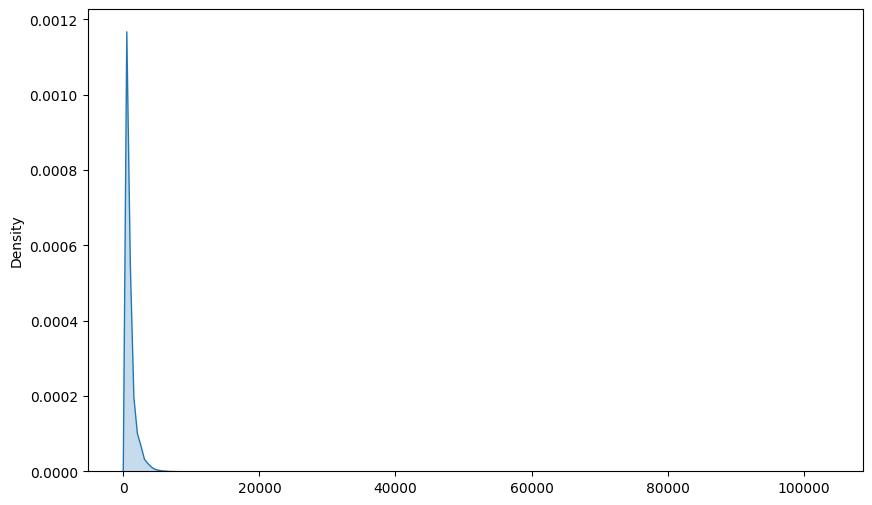

In [14]:
data = vis_bam_record_len(root_dir / f"data/direct_rna/{direc_rna_samples[0]}.npy")

In [21]:
max(data)

103380

In [25]:
d2 = list(data)

In [27]:
d2.remove(103380)

In [28]:
max(d2)

37862

<Axes: ylabel='Density'>

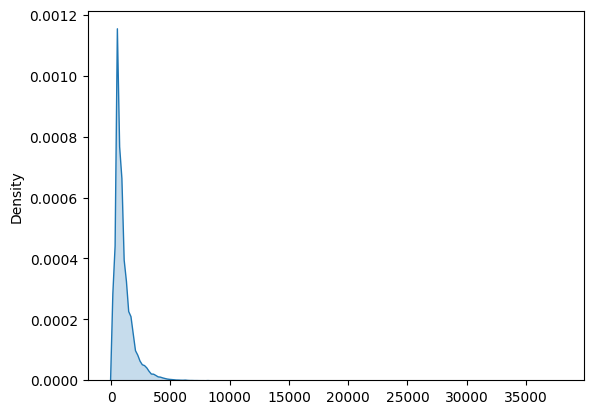

In [29]:
sns.kdeplot(d2, fill=True)

In [32]:
data.sort()

<Axes: ylabel='Density'>

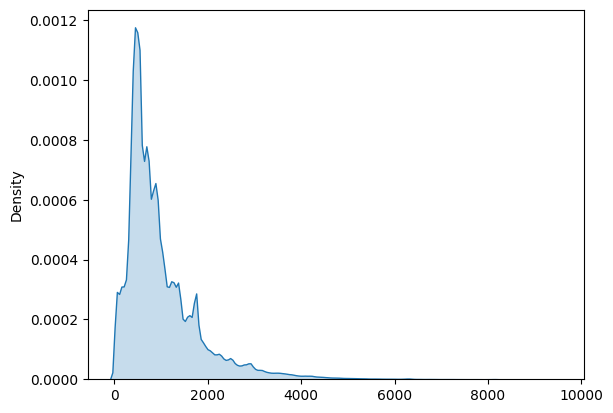

In [43]:
sns.kdeplot(data[:-800], fill=True)

In [47]:
des = pd.Series(data).describe()

# 2. Build Model

In [101]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import TrainingArguments, Trainer, logging
import torch

max_lengths = {
        'hyenadna-tiny-1k-seqlen': 1024,
        'hyenadna-small-32k-seqlen': 32768,
        'hyenadna-medium-160k-seqlen': 160000,
        'hyenadna-medium-450k-seqlen': 450000,  # T4 up to here
        'hyenadna-large-1m-seqlen': 1_000_000,  # only A100 (paid tier)
    }
model_checkpoints = list(max_lengths.keys())

# instantiate pretrained model
checkpoint = 'hyenadna-small-32k-seqlen'
max_length = max_lengths[checkpoint]


# bfloat16 for better speed and reduced memory usage
model_name = f"LongSafari/{checkpoint}-hf"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
# model = AutoModelForSequenceClassification.from_pretrained(model_name, torch_dtype=torch.bfloat16, device_map="auto", trust_remote_code=True)

In [102]:
tokenizer.decode(tokenizer(seq)['input_ids'])

'GCAGCTATGAATGCAAGGCCACAAGGTGGATGGAAGAGTTGTGGAACCAAAGAGCTGTCTTCCAGAGAAGATTTCGAGATAAGTCGCCCATCAGTGAACAAGATATTGTTGGTGGCATTTGATGAGAACGTTCCAAGATTATTGACAGATTAGTGAAAAGTAAGATTGAAATCATGACTGACCGTAAGTGGCAAGAAAGGGCTTTTGCCTTTGTAACCTTTGACGACCATGACTCCGTGGATAAGATTGTCATTCAGAATACCATACTGTGAATGGCCACATCTTTATTGTGAAGTTAGAAAAGCCCTGTCAAAGCAAGAGATGAATCAGTGCTTCTCCAGCCAAAGAGGTCGAAGTGGTTCTGGAAACTTTGGTGGTGGTCGTGGAGGTGGTTTCGGTGGGAATGACAACTCGGTCGTGGAGGAAACTTCAGTGGTCGTGGTGGCTTTGGTGGCAGCCGTGGTGGTGGTGGATATGGTGGCAGTGGGGATGGCTATAATGGATTTGGTAATGATGGAAGCAATTTGGAGGTGGTGGAAGCTACAATGATTTTGGGAATTACAACAATCAGTCTTCAAATTTTGGACCCCTAGGAGGAAATTTTGGTAGAAGCTCTGGCCCCATGGCGGTGGAGGCCAAATACTTTTGCAAACCACGAAACCAAGGTGGCTATGGCGGTCCAGCAGCAGCAGTAGCTATGGCAGTGGCAGAAGATTTTAATTAGGAAACAAAGCTTAGCAGGAGAGGAGAGCCAGAGAAGTGACAGGGAAGTACAGGTTACAACAGATTTGTGAACTCAGCCCAAGCACAGTGGTGGCAGGGCCTAGCTGCTACAAAGAAGACATGTTTTAGACAAATACTCATGTGTATGGGCAAAACTTGAGGACTGTATTTGTGACTAACTGTATAACAGGTTATTTTAGTTTCTGTTTGTGGAAAGTGTAAAGCATTCCAACAAAGGTTTTTAATGTAGATTTTTTTTTTTGCACCCCATGCTGT

In [103]:
from transformers import AutoModel 
hyena_dna_model = AutoModel.from_pretrained(model_name,trust_remote_code=True)

In [104]:
hyena_dna_model

HyenaDNAModel(
  (backbone): HyenaLMBackbone(
    (embeddings): HyenaEmbeddings(
      (word_embeddings): Embedding(16, 256)
    )
    (dropout): Dropout(p=0.1, inplace=False)
    (layers): ModuleList(
      (0-3): 4 x HyenaBlock(
        (mixer): HyenaOperator(
          (dropout): Dropout(p=0.0, inplace=False)
          (in_proj): Linear(in_features=256, out_features=768, bias=True)
          (out_proj): Linear(in_features=256, out_features=256, bias=True)
          (short_filter): Conv1d(768, 768, kernel_size=(3,), stride=(1,), padding=(2,), groups=768)
          (filter_fn): HyenaFilter(
            (dropout): Dropout(p=0.0, inplace=False)
            (pos_emb): HyenaPositionalEmbedding()
            (implicit_filter): Sequential(
              (0): Linear(in_features=5, out_features=64, bias=True)
              (1): HyenaSin()
              (2): Linear(in_features=64, out_features=64, bias=True)
              (3): HyenaSin()
              (4): Linear(in_features=64, out_features=6

In [105]:
from transformers import DataCollatorForTokenClassification

In [107]:
data_collator = DataCollatorForTokenClassification(tokenizer)

In [89]:
tokenizer.padding_side

'left'

In [150]:
def test(dataset, max_length):
    quals =     [dataset['train']['qual'][0],dataset['train']['qual'][1] ]
    targets =   [dataset['train']['target'][0], dataset['train']['target'][1]]
    sequences = [dataset['train']['seq'][0], dataset['train']['seq'][1]] 
    tokenized =  tokenizer(sequences, max_length=max_length, truncation=True, padding=True)["input_ids"]
    labels =    [dataset['train']['label'][0], dataset['train']['label'][1]] 
    print(f"{sequence=}\n")
    print(f"{tokenized=}\n")
    print(f"{labels=}\n")
    print(f"{quals=}\n")
    


In [151]:
test(dataset_with_label, 2000)

sequence='GCAGCTATGAATGCAAGGCCACAAGGTGGATGGAAGAGTTGTGGAACCAAAGAGCTGTCTTCCAGAGAAGATTTCGAGATAAGTCGCCCATCAGTGAACAAGATATTGTTGGTGGCATTTGATGAGAACGTTCCAAGATTATTGACAGATTAGTGAAAAGTAAGATTGAAATCATGACTGACCGTAAGTGGCAAGAAAGGGCTTTTGCCTTTGTAACCTTTGACGACCATGACTCCGTGGATAAGATTGTCATTCAGAATACCATACTGTGAATGGCCACATCTTTATTGTGAAGTTAGAAAAGCCCTGTCAAAGCAAGAGATGAATCAGTGCTTCTCCAGCCAAAGAGGTCGAAGTGGTTCTGGAAACTTTGGTGGTGGTCGTGGAGGTGGTTTCGGTGGGAATGACAACTCGGTCGTGGAGGAAACTTCAGTGGTCGTGGTGGCTTTGGTGGCAGCCGTGGTGGTGGTGGATATGGTGGCAGTGGGGATGGCTATAATGGATTTGGTAATGATGGAAGCAATTTGGAGGTGGTGGAAGCTACAATGATTTTGGGAATTACAACAATCAGTCTTCAAATTTTGGACCCCTAGGAGGAAATTTTGGTAGAAGCTCTGGCCCCATGGCGGTGGAGGCCAAATACTTTTGCAAACCACGAAACCAAGGTGGCTATGGCGGTCCAGCAGCAGCAGTAGCTATGGCAGTGGCAGAAGATTTTAATTAGGAAACAAAGCTTAGCAGGAGAGGAGAGCCAGAGAAGTGACAGGGAAGTACAGGTTACAACAGATTTGTGAACTCAGCCCAAGCACAGTGGTGGCAGGGCCTAGCTGCTACAAAGAAGACATGTTTTAGACAAATACTCATGTGTATGGGCAAAACTTGAGGACTGTATTTGTGACTAACTGTATAACAGGTTATTTTAGTTTCTGTTTGTGGAAAGTGTAAAGCATTCCAACAAAGGTTTTTAATGTAGATTTTTTTTTTTGCACC

In [10]:

# Generate some random sequence and labels
# If you're copying this code, replace the sequences and labels
# here with your own data!
# sequence = 'ACTG' * int(max_length/4)
# sequence = [sequence] * 8  # Create 8 identical samples
# tokenized = tokenizer(sequence)["input_ids"]
# labels = [0, 1] * 4

sequence = [seq]
tokenized = tokenizer(sequence)["input_ids"]
labels = label

# Create a dataset for training
ds = Dataset.from_dict({"input_ids": tokenized, "labels": labels})
ds.set_format("pt")

# Initialize Trainer
# Note that we're using extremely small batch sizes to maximize
# our ability to fit long sequences in memory!
args = {
    "output_dir": "tmp",
    "num_train_epochs": 1,
    "per_device_train_batch_size": 1,
    "gradient_accumulation_steps": 4,
    "gradient_checkpointing": True,
    "learning_rate": 2e-5,
}
training_args = TrainingArguments(**args)

trainer = Trainer(model=model, args=training_args, train_dataset=ds)
result = trainer.train()

print(result)

# Now we can save_pretrained() or push_to_hub() to share the trained model!


ArrowInvalid: Column 1 named labels expected length 1382 but got length 1381

In [6]:
result

TrainOutput(global_step=2, training_loss=0.775390625, metrics={'train_runtime': 23.1754, 'train_samples_per_second': 0.345, 'train_steps_per_second': 0.086, 'total_flos': 50280844173312.0, 'train_loss': 0.775390625, 'epoch': 1.0})